In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from rdkit import Chem
import requests
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import DBSCAN

# set seed 
torch.manual_seed(0)
np.random.seed(0)


/home/teddy/miniconda3/envs/tkgdti/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# CHEMBERTa; drug-similar-drug

In [ ]:
model_name = "seyonec/ChemBERTa-zinc-base-v1"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [3]:
drug_info = pd.read_csv('../../extdata/meta/targetome__drug_targets_gene.csv')
smiles = drug_info['can_smiles'].unique().astype(str).tolist()
max_len = max([len(s) for s in smiles]) + 1
print('max token length:', max_len)

max token length: 131


In [ ]:
inputs = tokenizer(
    smiles,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_len  # Adjust max_length as needed
)

In [ ]:
with torch.no_grad():
    outputs = model(**inputs)

In [ ]:
outputs.last_hidden_state.shape

torch.Size([89, 96, 768])

In [ ]:
z_drug = outputs.last_hidden_state[:, 0, :].numpy() # extract the [CLS] token embedding

In [8]:
z_drug.shape


(89, 768)

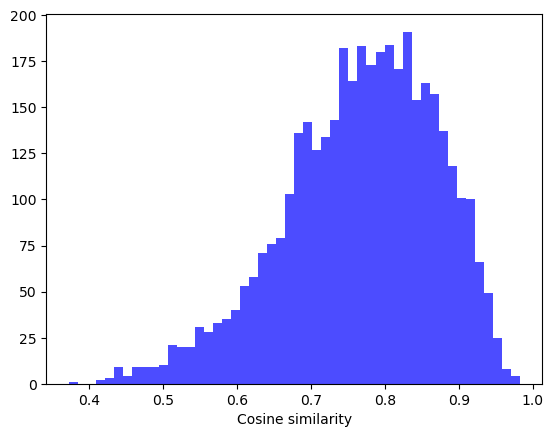

In [9]:
# Compute the cosine similarity matrix
cosine_sim_matrix = cosine_similarity(z_drug)

# Remove self similarities by setting the diagonal to 0
np.fill_diagonal(cosine_sim_matrix, 0)

# Extract the upper triangle of the cosine similarity matrix
upper_triangle_indices = np.triu_indices_from(cosine_sim_matrix, k=1)
upper_triangle_values = cosine_sim_matrix[upper_triangle_indices]

plt.figure()
plt.hist(upper_triangle_values, bins=50, alpha=0.7, color='b')
plt.xlabel('Cosine similarity')
plt.show() 

In [10]:
# Initialize an empty list to store the combined embeddings
combined_embeddings = []
cos_sim = []
drug_i = [] 
drug_j = [] 

# Iterate over the upper triangle indices
for i in range(len(smiles)):
    for j in range(len(smiles)):
        if i == j:
            continue
        combined_embedding = np.abs(z_drug[i] - z_drug[j])
        combined_embeddings.append(combined_embedding)
        cos_sim.append(cosine_similarity([z_drug[i]], [z_drug[j]])[0][0])
        drug_i.append(i)
        drug_j.append(j)

# Convert the list to a numpy array
combined_embeddings = np.array(combined_embeddings)

combined_embeddings.shape

(7832, 768)

In [11]:
np.unique(combined_embeddings, axis=0).shape

(3916, 768)

In [12]:

# agg results 
results = pd.DataFrame({
    'drug_i': drug_i,
    'drug_j': drug_j,
    'cos_sim': cos_sim,
})

results = results.assign(smiles_i = [smiles[i] for i in results['drug_i']],
                         smiles_j = [smiles[j] for j in results['drug_j']])

cos_sim_thresh = np.quantile(results['cos_sim'], 0.95)
print(f'Cosine similarity threshold: {cos_sim_thresh:.2f}')
results = results.assign(is_similar=results['cos_sim'] > cos_sim_thresh)


s2i = drug_info[['can_smiles', 'inchikey']].drop_duplicates()
results = results.merge(s2i, left_on='smiles_i', right_on='can_smiles', how='left').drop(columns='can_smiles')
results = results.merge(s2i, left_on='smiles_j', right_on='can_smiles', how='left').drop(columns='can_smiles')

results.head()

Cosine similarity threshold: 0.92


,drug_i,drug_j,cos_sim,smiles_i,smiles_j,is_similar,inchikey_x,inchikey_y
0,0,1,0.606698,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,CC1=C(C(=O)N(C2=NC(=NC=C12)NC3=NC=C(C=C3)N4CCN...,False,HPLNQCPCUACXLM-PGUFJCEWSA-N,AHJRHEGDXFFMBM-UHFFFAOYSA-N
1,0,2,0.807199,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,CN1CCC(C(C1)O)C2=C(C=C(C3=C2OC(=CC3=O)C4=CC=CC...,False,HPLNQCPCUACXLM-PGUFJCEWSA-N,BIIVYFLTOXDAOV-YVEFUNNKSA-N
2,0,3,0.770142,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,B(C(CC(C)C)NC(=O)C(CC1=CC=CC=C1)NC(=O)C2=NC=CN...,False,HPLNQCPCUACXLM-PGUFJCEWSA-N,GXJABQQUPOEUTA-RDJZCZTQSA-N
3,0,4,0.820911,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,CCN1CCN(CC1)CC2=C(C=C(C=C2)NC(=O)NC3=CC=C(C=C3...,False,HPLNQCPCUACXLM-PGUFJCEWSA-N,ODPGGGTTYSGTGO-UHFFFAOYSA-N
4,0,5,0.812793,CN(C)CCC(CSC1=CC=CC=C1)NC2=C(C=C(C=C2)S(=O)(=O...,CN1CCN(CC1)CCCOC2=C(C=C3C(=C2)N=CC(=C3NC4=CC(=...,False,HPLNQCPCUACXLM-PGUFJCEWSA-N,UBPYILGKFZZVDX-UHFFFAOYSA-N


In [13]:
results.to_csv('../../extdata/meta/chemberta_drug_drug_similarity.csv', index=False)

In [14]:
sim_relations = results[results['is_similar']]
sim_relations = sim_relations[['inchikey_x', 'inchikey_y']].rename({'inchikey_x': 'src', 'inchikey_y': 'dst'}, axis=1)
sim_relations = sim_relations.assign(src_type = 'drug', dst_type = 'drug', relation = 'chemberta_cosine_similarity')
sim_relations.to_csv('../../extdata/relations/chemberta_drug_cosine_similarity.csv', index=False)
sim_relations.head()

,src,dst,src_type,dst_type,relation
356,ODPGGGTTYSGTGO-UHFFFAOYSA-N,UBPYILGKFZZVDX-UHFFFAOYSA-N,drug,drug,chemberta_cosine_similarity
362,ODPGGGTTYSGTGO-UHFFFAOYSA-N,UHTHHESEBZOYNR-UHFFFAOYSA-N,drug,drug,chemberta_cosine_similarity
363,ODPGGGTTYSGTGO-UHFFFAOYSA-N,LGLHCXISMKHLIK-UHFFFAOYSA-N,drug,drug,chemberta_cosine_similarity
392,ODPGGGTTYSGTGO-UHFFFAOYSA-N,OUKYUETWWIPKQR-UHFFFAOYSA-N,drug,drug,chemberta_cosine_similarity
400,ODPGGGTTYSGTGO-UHFFFAOYSA-N,DESOLSKAHZZIGK-UHFFFAOYSA-N,drug,drug,chemberta_cosine_similarity


In [15]:
len(sim_relations)

392